In [1]:
DIR='/scratch/tm70/as2285/access-om2/archive/'

In [2]:
RUNS = {
    "new_grid_1deg": ["1deg_jra55_ryf-new_grid-3028a7b3"],  # (our name: run name(s))
    "old_grid_1deg": ["1deg_jra55_ryf"],
    "new_grid_025deg" : ["dev-025deg_jra55_ryf-dev-025deg_jra55_ryf-6d175d1a"]
}

In [3]:
for r in RUNS.keys():
    print(r)
    ! cat {DIR}{RUNS[r][0]}/output000/manifests/input.yaml | grep /grid.nc

new_grid_1deg
work/ice/RESTART/grid.nc:
  fullpath: /g/data/tm70/as2285/om3-scripts/grid_generation/1deg/grid.nc
old_grid_1deg
work/ice/RESTART/grid.nc:
  fullpath: /g/data/vk83/experiments/inputs/access-om2/ice/grids/global.1deg/2020.05.30/grid.nc
new_grid_025deg
work/ice/RESTART/grid.nc:
  fullpath: /g/data/tm70/as2285/om3-scripts/grid_generation/025deg/grid.nc


In [4]:
from access_nri_intake.source.builders import AccessOm2Builder
from intake import open_esm_datastore

from dask.distributed import Client

import xarray as xr
from datatree import DataTree, map_over_subtree
import cf_xarray as cfxr

import matplotlib.pyplot as plt

In [5]:
import intake

In [6]:
client=Client(threads_per_worker=1)

In [7]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 48
Total threads: 48,Total memory: 188.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41345,Workers: 48
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 188.55 GiB
Comm: tcp://127.0.0.1:40989,Total threads: 1
Dashboard: /proxy/45623/status,Memory: 3.93 GiB
Nanny: tcp://127.0.0.1:44939,


### Make an esm datastore for each experiment

In [8]:
for s_name,l_name in RUNS.items():
    builder = AccessOm2Builder(DIR+l_name[0])
    builder.build()
    builder.save(s_name, l_name[0])

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/access_nri_intake/source/utils.py:37: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/access_nri_intake/source/utils.py:37: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/access_nri_intake/source/utils.py:37: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/access_nri_intake/source/utils.py:37: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/

Successfully wrote ESM catalog json file to: file:///home/603/as2285/new_grid_1deg.json


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/access_nri_intake/source/utils.py:37: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/access_nri_intake/source/utils.py:37: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/access_nri_intake/source/utils.py:37: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/access_nri_intake/source/utils.py:37: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/

Successfully wrote ESM catalog json file to: file:///home/603/as2285/old_grid_1deg.json


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/access_nri_intake/source/utils.py:37: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/access_nri_intake/source/utils.py:37: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/access_nri_intake/source/utils.py:37: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/access_nri_intake/source/utils.py:37: UserWarning: Time coordinate does not include bounds information. Guessing start and end times.
  warnings.warn(


Successfully wrote ESM catalog json file to: file:///home/603/as2285/new_grid_025deg.json


In [9]:
datastores = dict()

In [10]:
for s_name in RUNS.keys():
    datastores[s_name]= open_esm_datastore(
        s_name+'.json', 
        columns_with_iterables=["variable"] 
    )

In [11]:
datastores['new_grid_025deg'].search(realm="seaIce", variable="hi")

,unique
path,96
realm,1
variable,29
frequency,1
start_date,96
end_date,96
variable_long_name,1
variable_standard_name,1
variable_cell_methods,1
variable_units,1


In [12]:
catalog = intake.cat.access_nri

### Load some data

In [13]:
VARS = ["aice", "hi","vice"] # "uvel", "vvel" ]  
VARS_2D = ["area_t", "geolat_t", "geolon_t"]

In [14]:
def open_by_name(datastores,name, vars):
    """Return a dataset for the requested name and vars"""
    return (
        datastores[name]
        .search(variable=vars)
        .to_dask(
            xarray_open_kwargs={
                "decode_coords": False,
            },
            xarray_combine_by_coords_kwargs={
                "compat": "override",
                "data_vars": "minimal",
                "coords": "minimal",
            },
        )
    )

In [15]:
def open_by_experiment(datastores,exp_name, vars):
    """Concatenate any datasets provided for this experiment into one ds, and add area and geo coordinates"""
    from datetime import timedelta

    # get the data for each run of this config
    cice_ds = xr.concat(
        [open_by_name(datastores,iName, vars) for iName in [exp_name]], dim="time"
    )

    # We also want the area/lat/lon fields, but these are not time dependent.
    area_ds = xr.merge(
        [
            xr.open_dataset(
                datastores[exp_name].search(variable=iVar).df.path[0]
                # path of the first file with the area field, the geolon field and the geolat field
            ).drop_vars("time")
            for iVar in VARS_2D
        ]
    )

    # Label the lats and lons
    cice_ds.coords["ni"] = area_ds["xt_ocean"].values
    cice_ds.coords["nj"] = area_ds["yt_ocean"].values

    # Copy attributes for cf compliance
    cice_ds.ni.attrs = area_ds.xt_ocean.attrs
    cice_ds.nj.attrs = area_ds.yt_ocean.attrs

    cice_ds = cice_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))

    # Add the geolon, geolat, and area as extra co-ordinates fields from area_t

    cice_ds = cice_ds.assign_coords(
        {
            "geolat_t": area_ds.geolat_t,
            "geolon_t": area_ds.geolon_t,
            "area_t": area_ds.area_t,
        }
    )

    # cice timestamps are also misleading:
    cice_ds["time"] = cice_ds.time.to_pandas() - timedelta(minutes=1)

    return cice_ds

In [16]:
%%time

si_name_ds_pairs = [(iRun, open_by_experiment(datastores,iRun, VARS)) for iRun in RUNS.keys()]

CPU times: user 13.8 s, sys: 1.78 s, total: 15.6 s
Wall time: 25.7 s


The normal run (025deg_jra55_ryf9091_gadi) doesnt have daily cice data, so using this one done by ryan for the Era5 comparison work

In [17]:
catalog.search(model='ACCESS-OM2')

,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{ocean, seaIce}","{1day, fx, 3hr, 1mon, 3mon}","{opening_m, sst_m, ANGLE, ht, HTN, temp_global_ave, age_global, alidf_ai_m, u, area_u, total_ocean_evap, sig2_m, alvdf_ai_m, pme_river, total_ocean_sens_heat, vsurf, pbot_t, sfc_hflux_coupler, sur..."
01deg_jra55v140_iaf,{ACCESS-OM2},{Cycle 1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{ocean, seaIce}","{1day, fx, 1mon}","{hs, opening_m, ANGLE, ht, HTN, temp_global_ave, congel, age_global, alidf_ai_m, u, area_u, total_ocean_evap, alvdf_ai_m, total_ocean_sens_heat, pme_river, pbot_t, sfc_hflux_coupler, snoice, surfa..."
01deg_jra55v140_iaf_cycle2,{ACCESS-OM2},{Cycle 2 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{ocean, seaIce}","{1day, fx, 1mon}","{hs, opening_m, ANGLE, ht, melts_m, HTN, temp_global_ave, congel, surface_pot_temp, age_global, meltb_m, alidf_ai_m, u, area_u, total_ocean_evap, alvdf_ai_m, total_ocean_sens_heat, pme_river, vsur..."
01deg_jra55v140_iaf_cycle3,{ACCESS-OM2},{Cycle 3 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{ocean, seaIce}","{1day, fx, 1mon}","{hs, opening_m, ANGLE, ht, melts_m, HTN, temp_global_ave, congel, surface_pot_temp, age_global, meltb_m, alidf_ai_m, u, area_u, total_ocean_evap, alvdf_ai_m, total_ocean_sens_heat, pme_river, vsur..."
01deg_jra55v140_iaf_cycle4,{ACCESS-OM2},{Cycle 4 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0 OMIP2 interannual forcing},"{ocean, seaIce}","{1day, fx, 3hr, 1mon, 6hr}","{caco3, pprod_gross, hs, surface_zoo, HTN, surface_pot_temp, age_global, paco2, alvdf_ai_m, stf03, eta_global, surface_phy, albsni_m, meltt, no3_yflux_adv, total_ocean_mh_flux, alidf_ai, adic, tem..."
01deg_jra55v140_iaf_cycle4_jra55v150_extension,{ACCESS-OM2},{Extensions of cycle 4 of 0.1 degree ACCESS-OM2 + WOMBAT BGC global model configuration with JRA55-do v1.5.0 and v1.5.0.1 interannual forcing},"{ocean, seaIce}","{1day, fx, 1mon, subhr}","{caco3, dic_xflux_adv, pprod_gross, hs, surface_zoo, opening_m, no3_intmld, salt_xflux_adv, ANGLE, ht, melts_m, HTN, temp_global_ave, congel, surface_pot_temp, age_global, meltb_m, alidf_ai_m, pac..."
01deg_jra55v150_iaf_cycle1,{ACCESS-OM2},{Cycle 1 of 0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.5.0 OMIP2 interannual forcing},"{ocean, seaIce}","{1day, fx, 1mon}","{ht, surface_pot_temp, age_global, u, area_u, pme_river, pbot_t, sfc_hflux_coupler, surface_salt, sea_level, eta_t, hi_m, evap_heat, ULON, dyt, time_bounds, wfiform, drag_coeff, pot_rho_2, frazil_..."
025deg_era5_iaf,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with ERA5 interannual\nforcing (1980-2021)},"{ocean, seaIce}","{1day, fx, 1mon}","{fsens_ai_m, hs, flat_ai_m, opening_m, ANGLE, ht, melts_m, HTN, temp_global_ave, congel, surface_pot_temp, meltb_m, alidf_ai_m, u, area_u, total_ocean_evap, alvdf_ai_m, total_ocean_sens_heat, pme_..."
025deg_era5_ryf,{ACCESS-OM2},{0.25 degree ACCESS-OM2 global model configuration with ERA5 RYF9091 repeat\nyear forcing (May 1990 to Apr 1991)},"{ocean, seaIce}","{1day, fx, 1mon}","{agm, fsens_ai_m, hs, flat_ai_m, opening_m, ANGLE, ht, melts_m, HTN, temp_global_ave, congel, surface_pot_temp, age_global, meltb_m, alidf_ai_m, u, area_u, total_ocean_evap, alvdf_ai_m, total_ocea..."


In [18]:
si_name_ds_pairs.append((
    '025deg_jra55_ryf_era5comparison',
    open_by_experiment(catalog,"025deg_jra55_ryf_era5comparison", VARS).sel(time=slice('1900','1910'))
))

In [19]:

si_dt = DataTree.from_dict(dict(si_name_ds_pairs))

# Calculate Sea Ice Area

Sea ice area is the circumpolar sum of sea ice concentration multiplied by the area of each grid cell. By convention, and because lower concentrations are not accurate when measured through remote sensing, concentrations below 0.15 are not included

In [20]:
def sea_ice_area(sic, area, range=[0.15, 1]):
    return (sic * area).where((sic >= range[0]) * (sic <= range[1])).cf.sum(["X", "Y"])

In [21]:
@map_over_subtree
def sea_ice_area_model(ds):
    sic = ds.aice.cf.sel(Y=slice(-90, 0))
    area_km2 = ds.area_t / 1e6

    result = sea_ice_area(sic, area_km2).to_dataset(name="sh_area")

    sic = ds.aice.cf.sel(Y=slice(0, 90))

    result=result.merge(sea_ice_area(sic, area_km2).to_dataset(name="nh_area"))
    
    return result

In [22]:
model_area_dt = sea_ice_area_model(si_dt)

1 deg

Text(0, 0.5, 'Area (km2)')

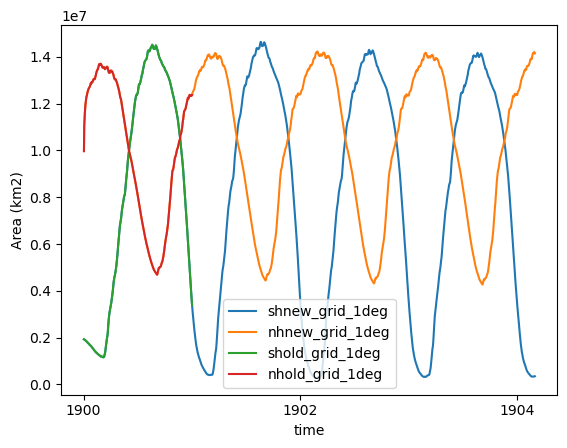

In [23]:
for s_name in ['new_grid_1deg', 'old_grid_1deg']:
    model_area_dt[s_name].sh_area.plot(label='sh'+s_name)
    model_area_dt[s_name].nh_area.plot(label='nh'+s_name)

plt.legend()
plt.ylabel('Area (km2)')

Text(0, 0.5, 'Area (km2)')

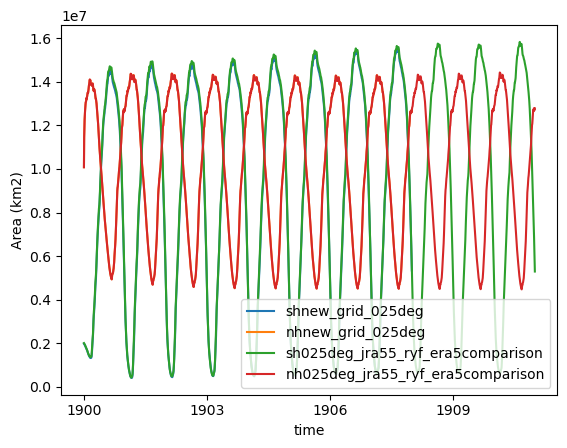

In [24]:
for s_name in ['new_grid_025deg', '025deg_jra55_ryf_era5comparison']:
    model_area_dt[s_name].sh_area.plot(label='sh'+s_name)
    model_area_dt[s_name].nh_area.plot(label='nh'+s_name)

plt.legend()
plt.ylabel('Area (km2)')

# Sea Ice Volume

In [25]:
ds = si_dt['new_grid_025deg'].ds

In [26]:
(ds.hi*ds.aice).cf.sel(Y=slice(-90, 0))

<xarray.DataArray (time: 2920, yt_ocean: 498, xt_ocean: 1440)> Size: 8GB
dask.array<getitem, shape=(2920, 498, 1440), dtype=float32, chunksize=(1, 498, 720), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 23kB 1900-01-01 23:59:00 ... 1907-12-31 23:59:00
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 4kB -81.08 -80.97 -80.87 ... -0.375 -0.125
    geolat_t  (yt_ocean, xt_ocean) float32 3MB nan nan nan ... -0.125 -0.125
    geolon_t  (yt_ocean, xt_ocean) float32 3MB nan nan nan ... 79.38 79.62 79.88
    area_t    (yt_ocean, xt_ocean) float32 3MB nan nan ... 7.728e+08 7.728e+08

In [27]:
@map_over_subtree
def sea_ice_vol_model(ds):
    vice = (ds.hi*ds.aice).cf.sel(Y=slice(-90, 0))
    area_m2 = ds.area_t

    result = (vice*area_m2).cf.sum(["X", "Y"]).to_dataset(name="sh_vol")

    vice = (ds.hi*ds.aice).cf.sel(Y=slice(0, 90))
    
    result=result.merge((vice*area_m2).cf.sum(["X", "Y"]).to_dataset(name="nh_vol"))
    
    return result

In [28]:
model_vol_dt = sea_ice_vol_model(si_dt)

Text(0, 0.5, 'vol (m3)')

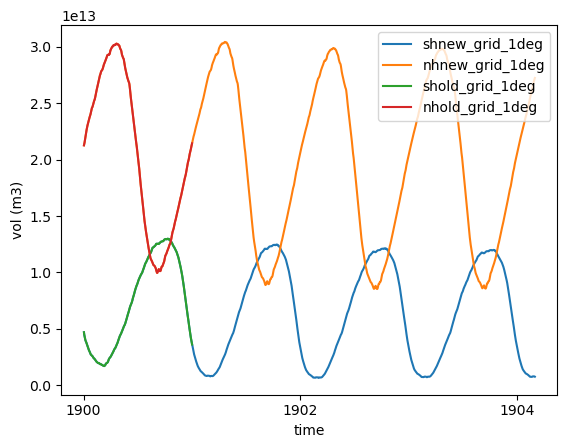

In [29]:
for s_name in ['new_grid_1deg', 'old_grid_1deg']:
    model_vol_dt[s_name].sh_vol.plot(label='sh'+s_name)
    model_vol_dt[s_name].nh_vol.plot(label='nh'+s_name)

plt.legend()
plt.ylabel('vol (m3)')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 11.41 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Text(0, 0.5, 'vol (m3)')

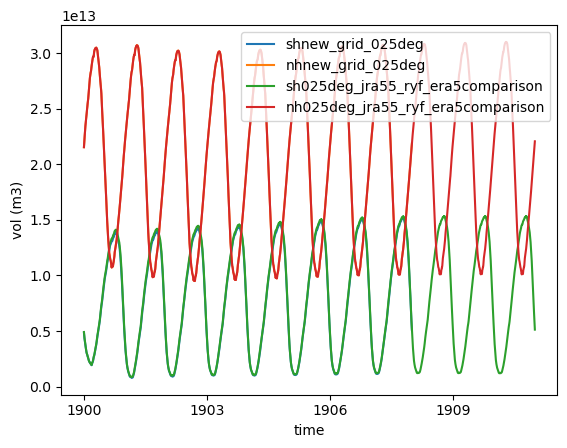

In [30]:
for s_name in ['new_grid_025deg', '025deg_jra55_ryf_era5comparison']:
    model_vol_dt[s_name].sh_vol.plot(label='sh'+s_name)
    model_vol_dt[s_name].nh_vol.plot(label='nh'+s_name)

plt.legend()
plt.ylabel('vol (m3)')

# Some differences in 1 deg conc

In [31]:
anoms = si_dt['new_grid_1deg']-si_dt['old_grid_1deg']

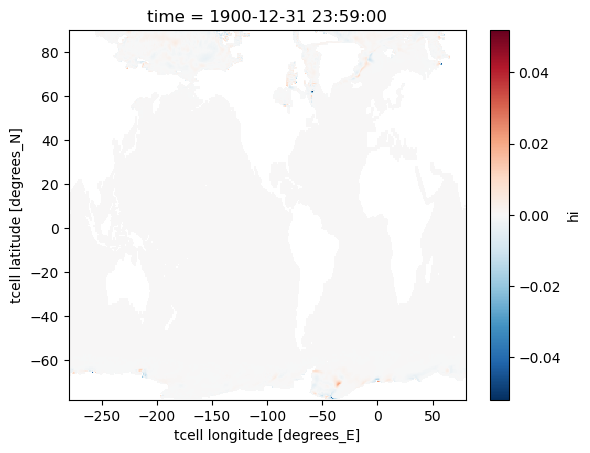

In [32]:
anoms.hi.isel(time=364).plot()

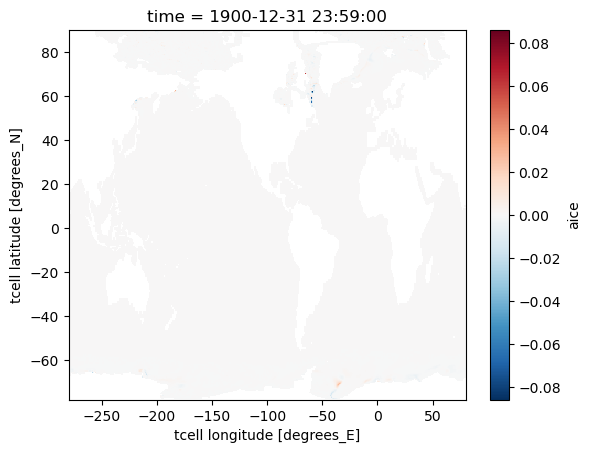

In [33]:
anoms.aice.isel(time=364).plot()

# And in 0.25 degree

In [34]:
anoms = si_dt['new_grid_025deg']-si_dt['025deg_jra55_ryf_era5comparison']

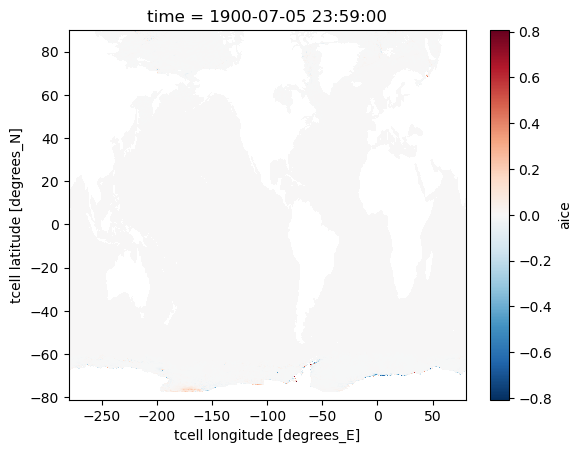

In [43]:
anoms.aice.isel(time=185).plot()

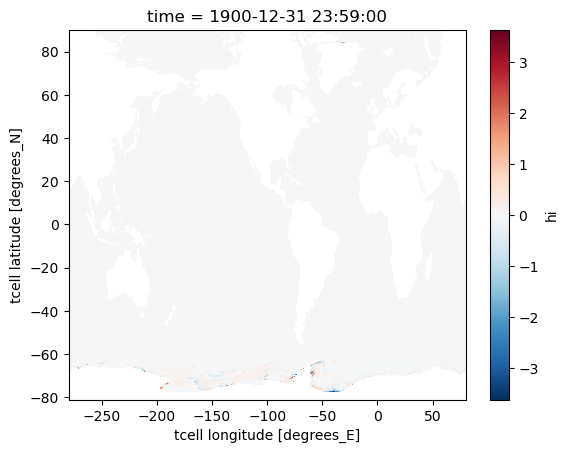

In [35]:
anoms.hi.isel(time=364).plot()

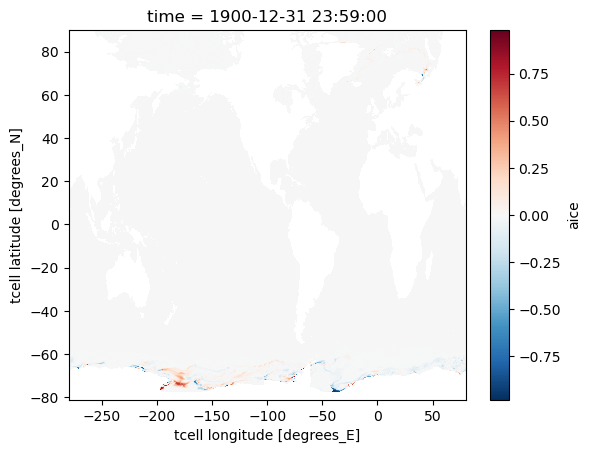

In [36]:
anoms.aice.isel(time=364).plot()

In [37]:
si_dt['025deg_jra55_ryf_era5comparison']

DataTree('025deg_jra55_ryf_era5comparison', parent="None")
    Dimensions:   (time: 4015, yt_ocean: 1080, xt_ocean: 1440)
    Coordinates:
      * time      (time) object 32kB 1900-01-01 23:59:00 ... 1910-12-31 23:59:00
      * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
      * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
        geolat_t  (yt_ocean, xt_ocean) float32 6MB ...
        geolon_t  (yt_ocean, xt_ocean) float32 6MB ...
        area_t    (yt_ocean, xt_ocean) float32 6MB nan nan nan nan ... nan nan nan
    Data variables:
        hi        (time, yt_ocean, xt_ocean) float32 25GB dask.array<chunksize=(1, 540, 720), meta=np.ndarray>
        aice      (time, yt_ocean, xt_ocean) float32 25GB dask.array<chunksize=(1, 540, 720), meta=np.ndarray>
    Attributes: (12/20)
        title:                                    sea ice model output for CICE
        contents:                                 Diagnostic and Prognostic Varia...
        source:                                   Los Alamos Sea Ice Model (CICE)...
        time_period_freq:                         day_1
        comment:                                  All years have exactly 365 days
        comment3:                                 seconds elapsed into model date...
        ...                                       ...
        intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,
        intake_esm_attrs:variable_cell_methods:   time: mean,,,,,,,,,,,,,,,,,,tim...
        intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
        intake_esm_attrs:file_id:                 iceh_XXXX_XX_daily
        intake_esm_attrs:_data_format_:           netcdf
        intake_esm_dataset_key:                   iceh_XXXX_XX_daily.1day

In [41]:
catalog["025deg_jra55_ryf_era5comparison"].df.path[0]

'/g/data/ik11/outputs/access-om2-025/025deg_jra55_ryf_era5comparison/output000/ice/OUTPUT/iceh.1900-01-daily.nc'

In [42]:
! cat /g/data/ik11/outputs/access-om2-025/025deg_jra55_ryf_era5comparison/metadata.yaml

contact: Ryan Holmes
email: ryan.holmes@bom.gov.au
created: 2022-05-13
name: 025deg_jra55_ryf_era5comparison
experiment_uuid: e8631e52-57cc-480d-8819-22274c8159c3
model:
  - ACCESS-OM2
nominal_resolution:
  - 0.25 degrees
version: 1
description: |-
  0.25 degree ACCESS-OM2 global model configuration with JRA55-do v1.4.0
  RYF9091 repeat year forcing (May 1990 to Apr 1991)
long_description: |-
  0.25 degree ACCESS-OM2 global model configuration under the RYF9091 Repeat
  Year Forcing strategy outlined by Stewart et al. (2020), 
  https://doi.org/10.1016/j.ocemod.2019.101557.
  The configuration is based on that described in Kiss et al. (2020),
  https://doi.org/10.5194/gmd-13-401-2020, but with many improvements.
  Initial conditions are WOA13v2 potential temperature and practical salinity.
  Run with JRA55-do v1.4.0 RYF9091 (1 May 1990 - 30 April 1991) repeated forcing
  with all solid runoff converted to liquid runoff with no heat transfer.
  Spin up starts from a nominal year of 1 Ja

In [52]:
! cat /g/data/ik11/outputs/access-om2-025/025deg_jra55_ryf_era5comparison/output000/manifests/input.yaml | grep grid.nc

work/ice/RESTART/grid.nc:
  fullpath: /g/data/ik11/inputs/access-om2/input_20201102/cice_025deg/grid.nc
work/ocean/INPUT/ocean_hgrid.nc:
  fullpath: /g/data/ik11/inputs/access-om2/input_20201102/mom_025deg/ocean_hgrid.nc
work/ocean/INPUT/ocean_vgrid.nc:
  fullpath: /g/data/ik11/inputs/access-om2/input_20201102/mom_025deg/ocean_vgrid.nc


In [44]:
datastores['new_grid_025deg'].df.path[0]

'/scratch/tm70/as2285/access-om2/archive/dev-025deg_jra55_ryf-dev-025deg_jra55_ryf-6d175d1a/output000/ice/OUTPUT/iceh.1900-01-daily.nc'

In [50]:
! cat /scratch/tm70/as2285/access-om2/archive/dev-025deg_jra55_ryf-dev-025deg_jra55_ryf-6d175d1a/output000/manifests/input.yaml | grep grid.nc

work/ice/RESTART/grid.nc:
  fullpath: /g/data/tm70/as2285/om3-scripts/grid_generation/025deg/grid.nc
work/ocean/INPUT/ocean_hgrid.nc:
  fullpath: /g/data/vk83/experiments/inputs/access-om2/ocean/grids/mosaic/global.025deg/2020.05.30/ocean_hgrid.nc
work/ocean/INPUT/ocean_vgrid.nc:
  fullpath: /g/data/vk83/experiments/inputs/access-om2/ocean/grids/vertical/global.025deg/2020.11.02/ocean_vgrid.nc


In [51]:
! ncdump -hs /g/data/tm70/as2285/om3-scripts/grid_generation/025deg/grid.nc

netcdf grid {
dimensions:
	nx = 1440 ;
	ny = 1080 ;
variables:
	double ulat(ny, nx) ;
		ulat:units = "radians" ;
		ulat:long_name = "Latitude of U points" ;
		ulat:standard_name = "latitude" ;
		ulat:_Storage = "chunked" ;
		ulat:_ChunkSizes = 540, 720 ;
		ulat:_DeflateLevel = 1 ;
		ulat:_Shuffle = "true" ;
		ulat:_Endianness = "little" ;
	double ulon(ny, nx) ;
		ulon:units = "radians" ;
		ulon:long_name = "Longitude of U points" ;
		ulon:standard_name = "longitude" ;
		ulon:_Storage = "chunked" ;
		ulon:_ChunkSizes = 540, 720 ;
		ulon:_DeflateLevel = 1 ;
		ulon:_Shuffle = "true" ;
		ulon:_Endianness = "little" ;
	double tlat(ny, nx) ;
		tlat:units = "radians" ;
		tlat:long_name = "Latitude of T points" ;
		tlat:standard_name = "latitude" ;
		tlat:_Storage = "chunked" ;
		tlat:_ChunkSizes = 540, 720 ;
		tlat:_DeflateLevel = 1 ;
		tlat:_Shuffle = "true" ;
		tlat:_Endianness = "little" ;
	double tlon(ny, nx) ;
		tlon:units = "radians" ;
		tlon:long_name = "Longitude of T points" ;
		tlon